In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import sin, cos, sqrt, atan2, radians, ceil
import folium
from folium import Map
from folium.plugins import HeatMapWithTime
import warnings
warnings.filterwarnings("ignore")

In [2]:
OUTPUT_ROOT = "/path/to/output"
GPS_PATH = f"{OUTPUT_ROOT}/gps_data"
METADATA_PATH = f"{OUTPUT_ROOT}/metadata"
NETWORK_PATH = f"{OUTPUT_ROOT}/network_data"
# check in config
PROFILE_NAME = "tartu_user_employed_walk"
MEAN_MOVE_SPEED_MS = 1.1

In [3]:
clean_profile_name = ' '.join(PROFILE_NAME.split('_'))

In [4]:
# download data
gps_all = pd.read_parquet(GPS_PATH, engine="pyarrow")
metadata_all = pd.read_parquet(METADATA_PATH, engine="pyarrow")
network_all = pd.read_parquet(NETWORK_PATH, engine="pyarrow")

In [5]:
# glimpse of data
display(gps_all.head())
display(metadata_all.head())
display(network_all.head())

,user_id,timestamp,lon,lat,profile_name
0,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:01:00,26.684442,58.365498,tartu_user_employed_walk
1,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:02:00,26.684491,58.365544,tartu_user_employed_walk
2,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:04:00,26.684469,58.365531,tartu_user_employed_walk
3,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:06:00,26.684469,58.365531,tartu_user_employed_walk
4,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:08:00,26.684469,58.365531,tartu_user_employed_walk


,user_id,home_id,work_id,regular_loc_array,network_name,profile_name
0,ad159750ac984d8d8148c57a43ae5123,30241908,229374456,"[990509027, 10743246091, 994929241, 9285312816...",tartu_walk,tartu_user_employed_walk
1,28b92366726a4021a0efae4ba4903d45,30236288,30241089,"[234170828, 2418291465, 10685266584, 420986702...",tartu_walk,tartu_user_employed_walk
2,a1ea0e78d19a41c4bddd66ca25815c73,227714013,30235659,"[6535357283, 30226115, 857856640, 181013519]",tartu_walk,tartu_user_employed_walk
3,8923a7c17ff342ceab558c86069436cb,228700365,30235872,"[11101814959, 425388019, 425388018, 357843706]",tartu_walk,tartu_user_employed_walk
4,d8cfcba9670f4625a6f6c8e803ab63b7,236859167,1147580898,"[7562619326, 6535357236, 7810323485, 659335886]",tartu_walk,tartu_user_employed_walk


,element_type,osmid,name,loc_type,centre_x,centre_y,network_name
0,node,2345996395,TÜ Geograafia osakond,hw,26.715520,58.373195,tartu_walk
1,way,30190910,None,hw,26.683441,58.351225,tartu_walk
2,way,30221534,None,hw,26.735223,58.389387,tartu_walk
3,way,30221538,None,hw,26.717757,58.346422,tartu_walk
4,way,30221540,None,hw,26.699989,58.365181,tartu_walk


In [6]:
# filter by profile
gps_profile = gps_all[gps_all['profile_name']==PROFILE_NAME].reset_index(drop=True)
metadata_profile = metadata_all[metadata_all['profile_name']==PROFILE_NAME].reset_index(drop=True)

In [7]:
# get GPS data and network of a random user
random_user_id = random.choice(gps_profile['user_id'].unique())
network_name = metadata_profile[metadata_profile['user_id']==random_user_id]['network_name'].unique()[0]
network_profile = network_all[network_all['network_name']==network_name].reset_index(drop=True)
gps_random_user = gps_profile[gps_profile['user_id']==random_user_id].reset_index(drop=True)

In [8]:
# prepare date strings for a map
gps_random_user['date'] = gps_random_user['timestamp'].dt.date.astype(str) + " (" + gps_random_user['timestamp'].dt.day_name().astype(str) + ")"
date_strings = list(gps_random_user['date'].unique())

In [9]:
# collect lat/lon for a map
# structure: [[[],[],[]...], [[],[],[]...]...]
grouped_data = gps_random_user.groupby('date')
lat_long_list = [groups[['lat', 'lon']].values.tolist() for key, groups in grouped_data]

In [10]:
# add anchors
metadata_user = metadata_profile[metadata_profile['user_id']==random_user_id]
home_anchor = network_profile[network_profile['osmid']==metadata_user['home_id'].values[0]][['centre_y', 'centre_x']].values.tolist()[0]
work_anchor = network_profile[network_profile['osmid']==metadata_user['work_id'].values[0]][['centre_y', 'centre_x']].values.tolist()[0]
regular_event_anchors = network_profile[network_profile['osmid'].isin(metadata_user['regular_loc_array'].values[0])][['centre_y', 'centre_x']].values.tolist()

In [11]:
# for visualising regular event anchors (a beauty purpose)
event_icons = ['picture-o', 'glass', 'shopping-cart', 'info', 'group', 'coffee']

In [12]:
# Tartu coordinates
city_lat = 58.378025
city_lon = 26.728493

m=Map(width=1250, 
      height=500,
      location=[city_lat, city_lon], 
      zoom_start=12, 
      min_zoom=3,
      max_bounds=True)

folium.Marker(
  location=home_anchor,
  popup='home', 
  icon=folium.Icon(color='lightgray', icon='home', prefix='fa')
).add_to(m)

folium.Marker(
  location=work_anchor,
  popup='work', 
  icon=folium.Icon(color='darkblue', icon='briefcase', prefix='fa')
).add_to(m)
for regular_event_anchor in regular_event_anchors:
    folium.Marker(
      location= regular_event_anchor,
      popup='regular event',
      icon=folium.Icon(icon=random.choice(event_icons), prefix='fa')
    ).add_to(m)

In [13]:
title_html = f'''
             <h3 align="center" style="font-size:15px"><b>GPS data visualisation for one user\
             ({clean_profile_name})</b></h3>
             '''
m.get_root().html.add_child(folium.Element(title_html))  
HeatMapWithTime(lat_long_list, radius=10, auto_play=True, index=date_strings, max_opacity=0.5, min_speed=2).add_to(m)
m.save(f'{OUTPUT_ROOT}/gps_visualisation_map.html')
m

In [14]:
# Some possible checks based on the map:

# Anchor points (work and events) are distributed within a buffer around a home anchor
# On a weekend there is no trajectory to a work anchor, but during weekdays a user always commute there - plot's rule
# During a period a user "visits" all or almost all anchor points, sometimes there could be a trajectory
# outside of a "usual environment" most probably a user "visits" a random event
# Around anchor points there is a dense red dot - stay activity
# Trajectories between anchors are more or less straight lines but with some chaotic points - moving activity

In [15]:
def distance_in_km(lat1,lon1,lat2,lon2):
    R = 6371 # Radius of the earth in km
    dLat = radians(lat2-lat1)
    dLon = radians(lon2-lon1)
    rLat1 = radians(lat1)
    rLat2 = radians(lat2)
    a = sin(dLat/2) * sin(dLat/2) + cos(rLat1) * cos(rLat2) * sin(dLon/2) * sin(dLon/2) 
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    d = R * c # Distance in km
    return d

In [16]:
def speed(dist_km, time_start, time_end):
    return round(dist_km / ((time_end - time_start).total_seconds()/3600), 1) if time_end > time_start else 0

In [17]:
def get_distance_and_speed(lat1, lon1, lat2, lon2, time_start, time_end): 
    dist_km = distance_in_km(lat1,lon1,lat2,lon2)
    speed_kmh = speed(dist_km, time_start, time_end)
    
    return speed_kmh

In [18]:
# all fuctions are used to calculate a speed column
def df_with_speed(df, user_column, lon_column, lat_column, timestamp_column): 
    
    df['lon_end'] = df[lon_column].shift(-1)
    df['lat_end'] = df[lat_column].shift(-1)
    df['timestamp_end']= df[timestamp_column].shift(-1)
    df_with_speed=pd.DataFrame()
    for i in df[user_column].unique():
        df_transitional=pd.DataFrame()
        df_transitional=df[df[user_column]==i]
        df_with_speed=pd.concat([df_with_speed, df_transitional])
        df_with_speed.drop(index=df_with_speed.index[-1],axis=0,inplace=True)
        
    df_with_speed['speed_kmh'] = df_with_speed.apply(
        lambda row: get_distance_and_speed(
        lat1=row[lat_column],
        lon1=row[lon_column],
        lat2=row['lat_end'],
        lon2=row['lon_end'], 
        time_start=row[timestamp_column], 
        time_end=row['timestamp_end']
    ),
    axis=1)
    
    df_with_speed.drop(columns = ['lat_end', 'lon_end', 'timestamp_end'], inplace = True)
    
    return df_with_speed

In [19]:
gps_profile_with_speed = df_with_speed(gps_profile, 'user_id', 'lon', 'lat', 'timestamp')

In [20]:
# take a look on a speed column
display(gps_profile_with_speed.head())

,user_id,timestamp,lon,lat,profile_name,speed_kmh
0,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:01:00,26.684442,58.365498,tartu_user_employed_walk,0.4
1,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:02:00,26.684491,58.365544,tartu_user_employed_walk,0.1
2,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:04:00,26.684469,58.365531,tartu_user_employed_walk,0.0
3,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:06:00,26.684469,58.365531,tartu_user_employed_walk,0.0
4,061af63cbd234db9b9e6830cce00dcbb,2022-07-18 00:08:00,26.684469,58.365531,tartu_user_employed_walk,0.1


In [21]:
def ms_to_kmh(speed_ms):
    return speed_ms * 3.6

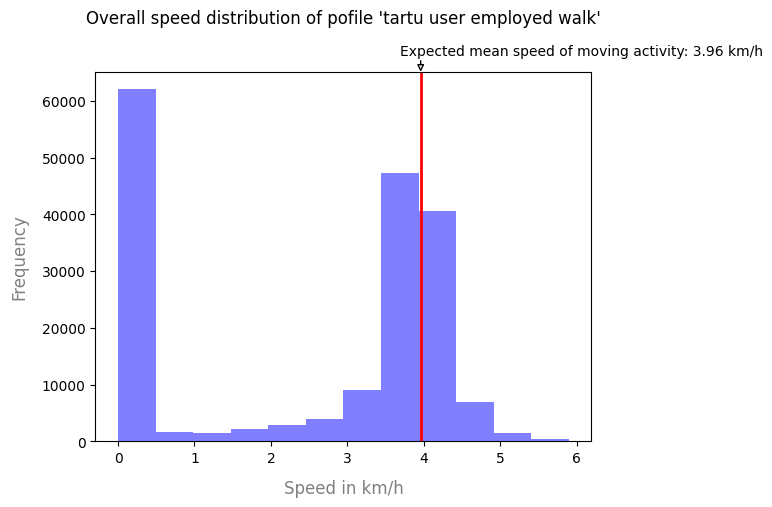

In [22]:
# choose a fraction value wisely, e.g. I expect my speed of moving activity 
# to be around 4 km/h (see MEAN_MOVE_SPEED_MS)
# thus for better visualisation I use 0.5 interval for bins
x_fraction=0.5
num_bins = ceil(gps_profile_with_speed['speed_kmh'].max()/x_fraction)

# The main idea of a plot is to:
# 1) Illustrate overall distribution of speed
# 2) Demostrate that speed does in fact reflect a speed of a walker
# 3) Show that MEAN_MOVE_SPEED_MS is in fact a mean value of a moving activity
fig, ax = plt.subplots()
ax.hist(gps_profile_with_speed['speed_kmh'], bins=num_bins, color='blue', alpha=0.5)

expected_mean_speed_kmh = round(ms_to_kmh(MEAN_MOVE_SPEED_MS),2)
real_mean_speed_kmh = round(gps_profile_with_speed['speed_kmh'].mean(), 2)
ax.axvline(expected_mean_speed_kmh, color='red', linewidth=2)

ax.annotate(f'Expected mean speed of moving activity: {expected_mean_speed_kmh} km/h', 
            xy=(expected_mean_speed_kmh, 1), 
            xytext=(-15, 15),
            xycoords=('data', 'axes fraction'), textcoords='offset points',
            horizontalalignment='left', verticalalignment='center',
            arrowprops=dict(arrowstyle='-|>', fc='white', shrinkA=0, shrinkB=0,       
                        connectionstyle='angle,angleA=0,angleB=90,rad=10'),)

ax.set_title(f"Overall speed distribution of pofile '{clean_profile_name}'",
            loc='center', 
            pad=35)
ax.set_xlabel("Speed in km/h", labelpad=10.0, color='grey', fontsize='large')
ax.set_ylabel("Frequency", labelpad=10.0, color='grey', fontsize='large')
plt.savefig(f'{OUTPUT_ROOT}/speed_distribution.png', bbox_inches='tight')
plt.show()

In [23]:
# The graph shows a bimodal distribution: one group stand for a stay activity, another - a moving activity
# MEAN_MOVE_SPEED_MS (converted to km/h) is indeed an average speed of users' movements